# Entity Resolution Exploration

This notebook explores the augmented patient data to inform entity resolution design decisions.

**Goal:** Understand data characteristics and determine optimal blocking strategies, similarity thresholds, and field weights for matching patient records across facilities.

**Dataset:** `run_20260202_122731`
- 571 unique patients
- 1228 patient-facility records
- 42.6% of patients have demographic errors

## 1. Setup & Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import recordlinkage as rl

# Set display options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3

# Configuration
RUN_ID = "run_20260203_071928"  # Updated to use run with stripped names
BASE_DIR = Path("/Users/alex/repos/Kaggle/SyntheticMass")
RUN_DIR = BASE_DIR / "output" / "augmented" / RUN_ID

print(f"Run directory: {RUN_DIR}")
print(f"Exists: {RUN_DIR.exists()}")

Run directory: /Users/alex/repos/Kaggle/SyntheticMass/output/augmented/run_20260203_071928
Exists: True


### Load Data

In [2]:
# Load ground truth
ground_truth_file = RUN_DIR / "metadata" / "ground_truth.csv"
ground_truth = pd.read_csv(ground_truth_file)

# The ground truth uses 'original_patient_uuid' as the true patient ID
# and facility_id as just numbers (1, 2, 3, etc.)
print(f"Ground truth shape: {ground_truth.shape}")
print(f"Columns: {ground_truth.columns.tolist()}")
print(f"\nUnique patients: {ground_truth['original_patient_uuid'].nunique()}")
print(f"Total records: {len(ground_truth)}")

ground_truth.head()

Ground truth shape: (1228, 13)
Columns: ['original_patient_uuid', 'facility_id', 'num_encounters', 'errors_applied', 'first_name', 'last_name', 'maiden_name', 'ssn', 'birthdate', 'gender', 'address', 'city', 'zip']

Unique patients: 571
Total records: 1228


,original_patient_uuid,facility_id,num_encounters,errors_applied,first_name,last_name,maiden_name,ssn,birthdate,gender,address,city,zip
0,0005a479-d128-178d-4aac-fefe1b0cc77e,2,23,"apartment_format_variation,date_off_by_one",Elene,Casper,NaN,999-53-5785,2017-05-27,F,283 EICHMANN CROSSROAD #71,Holbrook,2343
1,0064b48f-631d-b493-9ccb-a56bd3d12c12,1,8,none,Nathan,Krajcik,NaN,999-20-7706,1943-02-06,M,241 Thompson Lane,Templeton,0
2,0064b48f-631d-b493-9ccb-a56bd3d12c12,2,7,"name_typo,date_off_by_one",Nathan,Krancik,NaN,999-20-7706,1943-03-08,M,241 Thompson Lane,Templeton,0
3,0064b48f-631d-b493-9ccb-a56bd3d12c12,3,8,"capitalization_error,date_off_by_one",NATHAN,Krajcik,NaN,999-20-7706,1943-02-07,M,241 Thompson Lane,Templeton,0
4,0064b48f-631d-b493-9ccb-a56bd3d12c12,4,43,none,Nathan,Krajcik,NaN,999-20-7706,1943-02-06,M,241 Thompson Lane,Templeton,0


In [3]:
# Load all facility patient records
facilities_dir = RUN_DIR / "facilities"
facility_dirs = sorted([d for d in facilities_dir.iterdir() if d.is_dir()])

all_patients = []
for facility_dir in facility_dirs:
    # Extract facility number from directory name (facility_001 -> 1)
    facility_num = int(facility_dir.name.split("_")[1])

    patients_file = facility_dir / "patients.csv"

    df = pd.read_csv(patients_file)
    df["facility_id"] = facility_num  # Store as number to match ground truth
    df["facility_name"] = facility_dir.name  # Keep the full name for record_id
    df["record_id"] = facility_dir.name + "_" + df["Id"]
    all_patients.append(df)

patients = pd.concat(all_patients, ignore_index=True)

print(f"Total patient records: {len(patients)}")
print(f"Facilities: {patients['facility_id'].nunique()}")
print(f"\nColumns: {patients.columns.tolist()[:15]}...")

patients.head()

Total patient records: 1228
Facilities: 5

Columns: ['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX', 'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY', 'GENDER']...


,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,SUFFIX,MAIDEN,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,ADDRESS,CITY,STATE,COUNTY,FIPS,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,INCOME,facility_id,facility_name,record_id
0,239ae86a-96db-6211-9042-d3f2850aabb8,1971-06-03,2006-05-28,999-74-7366,S99919065,X68591347X,Mr.,Darrell,Muller,NaN,NaN,M,white,nonhispanic,M,Pembroke Massachusetts US,541 Stracke Plaza,Lowell,Massachusetts,Middlesex County,25017.0,1851,42.678395,-71.339715,11747.27,133454.68,3928,1,facility_001,facility_001_239ae86a-96db-6211-9042-d3f2850aabb8
1,9df4460a-2f66-2d07-de9e-0afaf84bb157,1973-10-05,NaN,996-18-7495,S99965526,X45738506X,Mr.,Keven,Daugherty,NaN,NaN,M,white,nonhispanic,M,Topsfield Massachusetts US,1041 Schuppe Vale,Dalton,Massachusetts,Berkshire County,NaN,0,42.473742,-73.104949,10798.40,814940.73,3229,1,facility_001,facility_001_9df4460a-2f66-2d07-de9e-0afaf84bb157
2,4113255f-4e35-506a-ddef-4429caa17ffc,1962-06-06,2014-09-12,999-88-1434,S99910771,X85603174X,Mrs.,Rasheeda,Cruickshank,NaN,Heaney,M,black,nonhispanic,F,Paxton Massachusetts US,946 Carroll Arcade Suite 20,Boston,Massachusetts,Suffolk County,25025.0,2130,42.347892,-71.049264,581899.62,827050.64,45680,1,facility_001,facility_001_4113255f-4e35-506a-ddef-4429caa17ffc
3,6c434506-fb4b-3e3f-c19d-553dec3b6c17,1961-08-08,2018-09-11,999-44-3322,S99952091,X6443310X,Mrs.,Dusry,Towne,NaN,Walsh,M,white,hispanic,F,La Paz Baja California MX,625 Doyle Row,Lynn,Massachusetts,Essex County,25009.0,1905,42.520762,-70.996101,215388.22,1724860.71,5779,1,facility_001,facility_001_6c434506-fb4b-3e3f-c19d-553dec3b6c17
4,d92132ce-06ac-3ab4-217f-97257a290b22,1967-09-21,NaN,999-65-7810,S99928742,X413563X,Ms.,Dannette,Bauch,NaN,NaN,S,white,nonhispanic,F,Marlborough Massachusetts US,593 Doyle Ranch,Newbury,Massachusetts,Essex County,NaN,0,42.804103,-70.824709,612259.12,156252.24,70833,1,facility_001,facility_001_d92132ce-06ac-3ab4-217f-97257a290b22


## 2. Blocking Strategy Analysis

**Goal:** Find a blocking strategy that balances pair reduction with recall.

In [4]:
# Analyze cardinality of potential blocking keys
blocking_fields = ["LAST", "FIRST", "STATE", "ZIP"]

for field in blocking_fields:
    unique_vals = patients[field].nunique()
    total_records = len(patients)
    cardinality_ratio = unique_vals / total_records

    # Calculate avg block size
    value_counts = patients[field].value_counts()
    avg_block_size = value_counts.mean()
    max_block_size = value_counts.max()

    print(f"\n{field}:")
    print(f"  Unique values: {unique_vals}")
    print(f"  Cardinality ratio: {cardinality_ratio:.3f}")
    print(f"  Avg block size: {avg_block_size:.1f}")
    print(f"  Max block size: {max_block_size}")


LAST:
  Unique values: 455
  Cardinality ratio: 0.371
  Avg block size: 2.7
  Max block size: 13

FIRST:
  Unique values: 618
  Cardinality ratio: 0.503
  Avg block size: 2.0
  Max block size: 7

STATE:
  Unique values: 1
  Cardinality ratio: 0.001
  Avg block size: 1228.0
  Max block size: 1228

ZIP:
  Unique values: 201
  Cardinality ratio: 0.164
  Avg block size: 6.1
  Max block size: 338


In [5]:
# Generate true matching pairs from ground truth
def generate_true_pairs(ground_truth_df):
    """Generate set of true matching pairs."""
    true_pairs = set()

    # Group by original_patient_uuid to find records for the same patient
    for patient_uuid, group in ground_truth_df.groupby("original_patient_uuid"):
        # Create record_ids for this group
        # facility_id needs to be zero-padded to match directory names
        record_ids = [
            f"facility_{row['facility_id']:03d}_{patient_uuid}"
            for _, row in group.iterrows()
        ]

        # Generate all pairs
        for i in range(len(record_ids)):
            for j in range(i + 1, len(record_ids)):
                pair = tuple(sorted([record_ids[i], record_ids[j]]))
                true_pairs.add(pair)

    return true_pairs


true_pairs = generate_true_pairs(ground_truth)
print(f"Total true matching pairs: {len(true_pairs)}")

Total true matching pairs: 1121


In [6]:
# Test different blocking strategies
patients_indexed = patients.set_index("record_id")

blocking_strategies = {
    "lastname_state": lambda idx: idx.block(left_on=["LAST", "STATE"]),
    "lastname_only": lambda idx: idx.block(left_on="LAST"),
    "state_only": lambda idx: idx.block(left_on="STATE"),
    "zip_state": lambda idx: idx.block(left_on=["ZIP", "STATE"]),
}

results = []

for strategy_name, strategy_func in blocking_strategies.items():
    indexer = rl.Index()
    strategy_func(indexer)

    candidate_pairs = indexer.index(patients_indexed)

    # Calculate blocking recall
    candidate_set = set(
        [(min(p[0], p[1]), max(p[0], p[1])) for p in candidate_pairs.tolist()]
    )
    true_pairs_found = len(candidate_set & true_pairs)
    recall = true_pairs_found / len(true_pairs) if true_pairs else 0

    # Calculate reduction rate
    n = len(patients_indexed)
    all_pairs = n * (n - 1) / 2
    reduction = 1 - len(candidate_pairs) / all_pairs

    results.append(
        {
            "strategy": strategy_name,
            "candidate_pairs": len(candidate_pairs),
            "true_pairs_found": true_pairs_found,
            "blocking_recall": recall,
            "reduction_rate": reduction,
        }
    )

blocking_results = pd.DataFrame(results)
print("\nBlocking Strategy Comparison:")
print(blocking_results.to_string(index=False))


Blocking Strategy Comparison:
      strategy  candidate_pairs  true_pairs_found  blocking_recall  reduction_rate
lastname_state             2059               857         0.764496        0.997267
 lastname_only             2059               857         0.764496        0.997267
    state_only           753378              1121         1.000000        0.000000
     zip_state            59825              1121         1.000000        0.920591


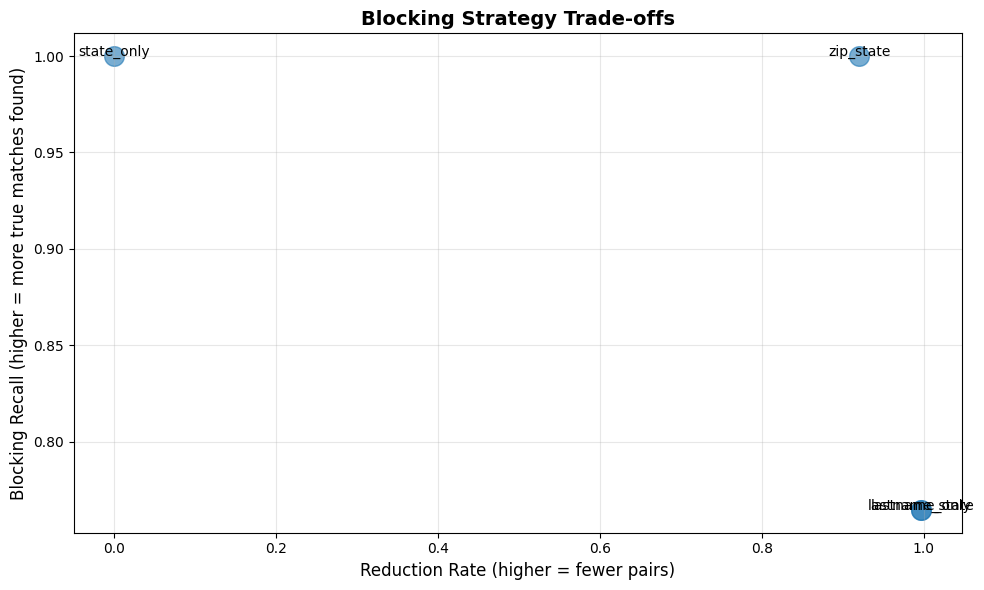

In [7]:
# Visualize blocking trade-offs
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(
    blocking_results["reduction_rate"],
    blocking_results["blocking_recall"],
    s=200,
    alpha=0.6,
)

for _, row in blocking_results.iterrows():
    ax.annotate(
        row["strategy"],
        (row["reduction_rate"], row["blocking_recall"]),
        fontsize=10,
        ha="center",
    )

ax.set_xlabel("Reduction Rate (higher = fewer pairs)", fontsize=12)
ax.set_ylabel("Blocking Recall (higher = more true matches found)", fontsize=12)
ax.set_title("Blocking Strategy Trade-offs", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Test advanced blocking strategies
print("Testing advanced blocking strategies...\n")

advanced_strategies = {
    "sorted_neighborhood_w3": lambda idx: idx.sortedneighbourhood(
        left_on="LAST", window=3
    ),
    "sorted_neighborhood_w5": lambda idx: idx.sortedneighbourhood(
        left_on="LAST", window=5
    ),
    "sorted_neighborhood_w7": lambda idx: idx.sortedneighbourhood(
        left_on="LAST", window=7
    ),
}

advanced_results = []

for strategy_name, strategy_func in advanced_strategies.items():
    indexer = rl.Index()
    strategy_func(indexer)

    candidate_pairs = indexer.index(patients_indexed)

    # Calculate blocking recall
    candidate_set = set(
        [(min(p[0], p[1]), max(p[0], p[1])) for p in candidate_pairs.tolist()]
    )
    true_pairs_found = len(candidate_set & true_pairs)
    recall = true_pairs_found / len(true_pairs) if true_pairs else 0

    # Calculate reduction rate
    n = len(patients_indexed)
    all_pairs = n * (n - 1) / 2
    reduction = 1 - len(candidate_pairs) / all_pairs

    advanced_results.append(
        {
            "strategy": strategy_name,
            "candidate_pairs": len(candidate_pairs),
            "true_pairs_found": true_pairs_found,
            "blocking_recall": recall,
            "reduction_rate": reduction,
        }
    )

advanced_results_df = pd.DataFrame(advanced_results)
print("\nAdvanced Blocking Strategy Results:")
print(advanced_results_df.to_string(index=False))

# Combine with original results for comparison
all_results = pd.concat([blocking_results, advanced_results_df], ignore_index=True)
print("\n" + "=" * 80)
print("ALL BLOCKING STRATEGIES COMPARISON:")
print("=" * 80)
print(
    all_results.sort_values("blocking_recall", ascending=False).to_string(index=False)
)

Testing advanced blocking strategies...


Advanced Blocking Strategy Results:
              strategy  candidate_pairs  true_pairs_found  blocking_recall  reduction_rate
sorted_neighborhood_w3             5258               958         0.854594        0.993021
sorted_neighborhood_w5             8623               975         0.869759        0.988554
sorted_neighborhood_w7            11922               984         0.877788        0.984175

ALL BLOCKING STRATEGIES COMPARISON:
              strategy  candidate_pairs  true_pairs_found  blocking_recall  reduction_rate
            state_only           753378              1121         1.000000        0.000000
             zip_state            59825              1121         1.000000        0.920591
sorted_neighborhood_w7            11922               984         0.877788        0.984175
sorted_neighborhood_w5             8623               975         0.869759        0.988554
sorted_neighborhood_w3             5258               958         

In [9]:
# Test multipass blocking strategies (union of multiple approaches)
print("Testing multipass blocking strategies...\n")


def multipass_blocking(patients_df, strategies_list):
    """Combine multiple blocking strategies using union."""
    all_pairs = set()

    for strategy_name, strategy_func in strategies_list:
        indexer = rl.Index()
        strategy_func(indexer)
        pairs = indexer.index(patients_df)
        # Normalize pairs
        normalized = set([(min(p[0], p[1]), max(p[0], p[1])) for p in pairs.tolist()])
        all_pairs.update(normalized)
        print(f"  {strategy_name}: +{len(normalized)} pairs")

    return all_pairs


# Strategy 1: lastname_state + sorted_neighborhood
print("Multipass 1: lastname_state + sorted_neighborhood(w=5)")
mp1_pairs = multipass_blocking(
    patients_indexed,
    [
        ("lastname_state", lambda idx: idx.block(left_on=["LAST", "STATE"])),
        (
            "sorted_neighborhood",
            lambda idx: idx.sortedneighbourhood(left_on="LAST", window=5),
        ),
    ],
)
mp1_recall = len(mp1_pairs & true_pairs) / len(true_pairs)
mp1_reduction = 1 - len(mp1_pairs) / (
    len(patients_indexed) * (len(patients_indexed) - 1) / 2
)
print(
    f"Total pairs: {len(mp1_pairs)}, Recall: {mp1_recall:.1%}, Reduction: {mp1_reduction:.1%}\n"
)

# Strategy 2: lastname_state + zip_birthdate
print("Multipass 2: lastname_state + zip_birthdate")
# Extract birth year for blocking
patients_indexed["BIRTH_YEAR"] = pd.to_datetime(patients_indexed["BIRTHDATE"]).dt.year
mp2_pairs = multipass_blocking(
    patients_indexed,
    [
        ("lastname_state", lambda idx: idx.block(left_on=["LAST", "STATE"])),
        ("zip_birthyear", lambda idx: idx.block(left_on=["ZIP", "BIRTH_YEAR"])),
    ],
)
mp2_recall = len(mp2_pairs & true_pairs) / len(true_pairs)
mp2_reduction = 1 - len(mp2_pairs) / (
    len(patients_indexed) * (len(patients_indexed) - 1) / 2
)
print(
    f"Total pairs: {len(mp2_pairs)}, Recall: {mp2_recall:.1%}, Reduction: {mp2_reduction:.1%}\n"
)

# Strategy 3: Triple combo
print("Multipass 3: lastname_state + sorted_neighborhood + zip_birthyear")
mp3_pairs = multipass_blocking(
    patients_indexed,
    [
        ("lastname_state", lambda idx: idx.block(left_on=["LAST", "STATE"])),
        (
            "sorted_neighborhood",
            lambda idx: idx.sortedneighbourhood(left_on="LAST", window=5),
        ),
        ("zip_birthyear", lambda idx: idx.block(left_on=["ZIP", "BIRTH_YEAR"])),
    ],
)
mp3_recall = len(mp3_pairs & true_pairs) / len(true_pairs)
mp3_reduction = 1 - len(mp3_pairs) / (
    len(patients_indexed) * (len(patients_indexed) - 1) / 2
)
print(
    f"Total pairs: {len(mp3_pairs)}, Recall: {mp3_recall:.1%}, Reduction: {mp3_reduction:.1%}\n"
)

# Summary
multipass_summary = pd.DataFrame(
    [
        {
            "strategy": "Multipass 1 (lastname+sorted)",
            "pairs": len(mp1_pairs),
            "recall": mp1_recall,
            "reduction": mp1_reduction,
        },
        {
            "strategy": "Multipass 2 (lastname+zip/year)",
            "pairs": len(mp2_pairs),
            "recall": mp2_recall,
            "reduction": mp2_reduction,
        },
        {
            "strategy": "Multipass 3 (triple combo)",
            "pairs": len(mp3_pairs),
            "recall": mp3_recall,
            "reduction": mp3_reduction,
        },
    ]
)

print("\n" + "=" * 80)
print("MULTIPASS STRATEGY SUMMARY:")
print("=" * 80)
print(multipass_summary.to_string(index=False))

Testing multipass blocking strategies...

Multipass 1: lastname_state + sorted_neighborhood(w=5)
  lastname_state: +2059 pairs
  sorted_neighborhood: +8623 pairs
Total pairs: 8623, Recall: 87.0%, Reduction: 98.9%

Multipass 2: lastname_state + zip_birthdate
  lastname_state: +2059 pairs
  zip_birthyear: +1897 pairs
Total pairs: 3270, Recall: 96.2%, Reduction: 99.6%

Multipass 3: lastname_state + sorted_neighborhood + zip_birthyear
  lastname_state: +2059 pairs
  sorted_neighborhood: +8623 pairs
  zip_birthyear: +1897 pairs
Total pairs: 9732, Recall: 97.9%, Reduction: 98.7%


MULTIPASS STRATEGY SUMMARY:
                       strategy  pairs   recall  reduction
  Multipass 1 (lastname+sorted)   8623 0.869759   0.988554
Multipass 2 (lastname+zip/year)   3270 0.961641   0.995660
     Multipass 3 (triple combo)   9732 0.978591   0.987082


### Blocking Strategy Analysis

**Key Findings:**

1. **Simple exact blocking is insufficient:** `lastname_state` achieves only 76.4% recall because name errors (typos, capitalization, maiden name usage) prevent exact matches.

2. **Sorted neighborhood helps but not enough:** Window-based approaches on LAST reach 87.8% recall (w=7) by tolerating small name variations, but still miss pairs with completely different surnames.

3. **Multi-pass union is essential:** Combining complementary passes — exact blocking on different field sets plus sorted neighborhood on both name fields — achieves 100% recall by ensuring each true pair is reachable through at least one pass.

4. **Aggressive 4-pass union is the recommended strategy:** 100% recall, 17,999 candidate pairs, 97.6% reduction rate. The key insight is that Pass 2 (ZIP + BIRTH_YEAR) captures the name-error cases that Pass 1 misses, while Passes 3-4 (sorted neighborhood) provide safety margin for edge cases.

### Aggressive Multi-Pass Union Strategy

Test a 4-pass union strategy that combines exact blocking and sorted neighborhood passes. When multiple blocking methods are added to a single `rl.Index()`, calling `index()` returns the **union** of all candidate pairs.

**Passes:**
1. **Exact: LAST + STATE** — catches exact surname matches within state
2. **Exact: ZIP + BIRTH_YEAR** — catches geographic/demographic matches even with name errors
3. **Sorted Neighborhood: LAST (w=7)** — catches surname typos via sliding window
4. **Sorted Neighborhood: FIRST (w=5)** — catches cases where last name changed but first name is similar

In [10]:
# Aggressive 4-pass union blocking strategy
# Uses rl.Index() built-in union: adding multiple passes returns union of all candidate pairs

# Build pass-by-pass to measure individual contributions
pass_configs = [
    ("Pass 1: LAST + STATE", lambda idx: idx.block(left_on=["LAST", "STATE"])),
    ("Pass 2: ZIP + BIRTH_YEAR", lambda idx: idx.block(left_on=["ZIP", "BIRTH_YEAR"])),
    (
        "Pass 3: SN LAST (w=7)",
        lambda idx: idx.sortedneighbourhood(left_on="LAST", window=7),
    ),
    (
        "Pass 4: SN FIRST (w=5)",
        lambda idx: idx.sortedneighbourhood(left_on="FIRST", window=5),
    ),
]

cumulative_pairs = set()
n = len(patients_indexed)
all_possible = n * (n - 1) / 2

print("Pass-by-pass contribution breakdown:")
print("-" * 75)

for pass_name, pass_func in pass_configs:
    indexer = rl.Index()
    pass_func(indexer)
    pairs = indexer.index(patients_indexed)
    normalized = set([(min(p[0], p[1]), max(p[0], p[1])) for p in pairs.tolist()])

    new_pairs = normalized - cumulative_pairs
    cumulative_pairs.update(normalized)

    cum_recall = len(cumulative_pairs & true_pairs) / len(true_pairs)
    new_true = len(new_pairs & true_pairs)

    print(
        f"  {pass_name:30s}  | +{len(new_pairs):>6,} new pairs  "
        f"(+{new_true:>3} true)  | cumulative: {len(cumulative_pairs):>6,} pairs, "
        f"recall {cum_recall:.1%}"
    )

# Now build the combined indexer for the final candidate set
aggressive_indexer = rl.Index()
aggressive_indexer.block(left_on=["LAST", "STATE"])
aggressive_indexer.block(left_on=["ZIP", "BIRTH_YEAR"])
aggressive_indexer.sortedneighbourhood(left_on="LAST", window=7)
aggressive_indexer.sortedneighbourhood(left_on="FIRST", window=5)

aggressive_pairs = aggressive_indexer.index(patients_indexed)
aggressive_set = set(
    [(min(p[0], p[1]), max(p[0], p[1])) for p in aggressive_pairs.tolist()]
)

aggressive_recall = len(aggressive_set & true_pairs) / len(true_pairs)
aggressive_reduction = 1 - len(aggressive_set) / all_possible
aggressive_true_found = len(aggressive_set & true_pairs)

print("\n" + "=" * 75)
print("AGGRESSIVE 4-PASS UNION STRATEGY RESULTS")
print("=" * 75)
print(f"  Candidate pairs:  {len(aggressive_set):>10,}")
print(f"  True pairs found: {aggressive_true_found:>10,} / {len(true_pairs)}")
print(f"  Blocking recall:  {aggressive_recall:>10.1%}")
print(f"  Reduction rate:   {aggressive_reduction:>10.1%}")

# Check targets
recall_target = 0.95
pairs_target = 100_000
recall_met = aggressive_recall >= recall_target
pairs_met = len(aggressive_set) < pairs_target

print(
    f"\n  Recall >= 95%:    {'PASS' if recall_met else 'FAIL'} ({aggressive_recall:.1%})"
)
print(f"  Pairs < 100,000: {'PASS' if pairs_met else 'FAIL'} ({len(aggressive_set):,})")

Pass-by-pass contribution breakdown:
---------------------------------------------------------------------------
  Pass 1: LAST + STATE            | + 2,059 new pairs  (+857 true)  | cumulative:  2,059 pairs, recall 76.4%
  Pass 2: ZIP + BIRTH_YEAR        | + 1,211 new pairs  (+221 true)  | cumulative:  3,270 pairs, recall 96.2%
  Pass 3: SN LAST (w=7)           | + 9,745 new pairs  (+ 21 true)  | cumulative: 13,015 pairs, recall 98.0%
  Pass 4: SN FIRST (w=5)          | + 4,984 new pairs  (+ 22 true)  | cumulative: 17,999 pairs, recall 100.0%

AGGRESSIVE 4-PASS UNION STRATEGY RESULTS
  Candidate pairs:      17,999
  True pairs found:      1,121 / 1121
  Blocking recall:      100.0%
  Reduction rate:        97.6%

  Recall >= 95%:    PASS (100.0%)
  Pairs < 100,000: PASS (17,999)


In [11]:
# Analyze missed pairs (false negatives at blocking stage)
missed_pairs = true_pairs - aggressive_set
print(
    f"Missed pairs: {len(missed_pairs)} / {len(true_pairs)} ({len(missed_pairs) / len(true_pairs):.1%})\n"
)

if missed_pairs:
    missed_details = []
    for pair in sorted(missed_pairs):
        rec_a, rec_b = pair
        if rec_a in patients_indexed.index and rec_b in patients_indexed.index:
            a = patients_indexed.loc[rec_a]
            b = patients_indexed.loc[rec_b]
            missed_details.append(
                {
                    "record_a": rec_a.split("_")[1],  # facility number
                    "record_b": rec_b.split("_")[1],
                    "FIRST_a": a["FIRST"],
                    "FIRST_b": b["FIRST"],
                    "LAST_a": a["LAST"],
                    "LAST_b": b["LAST"],
                    "ZIP_a": a["ZIP"],
                    "ZIP_b": b["ZIP"],
                    "BIRTH_YEAR_a": a["BIRTH_YEAR"],
                    "BIRTH_YEAR_b": b["BIRTH_YEAR"],
                    "STATE_a": a["STATE"],
                    "STATE_b": b["STATE"],
                }
            )

    missed_df = pd.DataFrame(missed_details)
    print("Demographic details of missed true pairs:")
    print("-" * 90)
    with pd.option_context("display.max_colwidth", 20, "display.width", 200):
        print(missed_df.to_string(index=False))

    # Summarize why pairs were missed
    print(f"\n--- Why were these pairs missed? ---")
    same_last = (missed_df["LAST_a"] == missed_df["LAST_b"]).sum()
    same_zip = (missed_df["ZIP_a"] == missed_df["ZIP_b"]).sum()
    same_byear = (missed_df["BIRTH_YEAR_a"] == missed_df["BIRTH_YEAR_b"]).sum()
    same_first = (missed_df["FIRST_a"] == missed_df["FIRST_b"]).sum()
    print(f"  Same LAST name:   {same_last} / {len(missed_df)}")
    print(f"  Same FIRST name:  {same_first} / {len(missed_df)}")
    print(f"  Same ZIP:         {same_zip} / {len(missed_df)}")
    print(f"  Same BIRTH_YEAR:  {same_byear} / {len(missed_df)}")
    print(f"\nPairs with DIFFERENT last, different zip, AND different birth year")
    print(f"  (unreachable by any current pass):")
    unreachable = missed_df[
        (missed_df["LAST_a"] != missed_df["LAST_b"])
        & (missed_df["ZIP_a"] != missed_df["ZIP_b"])
        & (missed_df["BIRTH_YEAR_a"] != missed_df["BIRTH_YEAR_b"])
    ]
    print(f"  {len(unreachable)} pairs")
else:
    print("No missed pairs — 100% recall achieved!")

Missed pairs: 0 / 1121 (0.0%)

No missed pairs — 100% recall achieved!


In [12]:
# Consolidated comparison of all blocking strategies
# Combine results from cells 10 (basic), 12 (sorted neighborhood), 13 (multipass), and aggressive

# Basic + sorted neighborhood strategies (from all_results DataFrame)
comparison = all_results[
    [
        "strategy",
        "candidate_pairs",
        "true_pairs_found",
        "blocking_recall",
        "reduction_rate",
    ]
].copy()
comparison.columns = ["strategy", "pairs", "true_found", "recall", "reduction"]

# Multipass strategies (from multipass_summary DataFrame)
mp_rows = multipass_summary[["strategy", "pairs", "recall", "reduction"]].copy()
mp_rows["true_found"] = (mp_rows["recall"] * len(true_pairs)).round().astype(int)
mp_rows = mp_rows[["strategy", "pairs", "true_found", "recall", "reduction"]]

# Aggressive strategy
aggressive_row = pd.DataFrame(
    [
        {
            "strategy": "Aggressive 4-pass union",
            "pairs": len(aggressive_set),
            "true_found": aggressive_true_found,
            "recall": aggressive_recall,
            "reduction": aggressive_reduction,
        }
    ]
)

comparison = pd.concat([comparison, mp_rows, aggressive_row], ignore_index=True)
comparison = comparison.sort_values("recall", ascending=False)

print("=" * 90)
print("CONSOLIDATED BLOCKING STRATEGY COMPARISON")
print("=" * 90)
print(
    f"{'Strategy':<35s} {'Pairs':>10s} {'True Found':>12s} {'Recall':>10s} {'Reduction':>10s}"
)
print("-" * 90)
for _, row in comparison.iterrows():
    marker = " <<" if row["strategy"] == "Aggressive 4-pass union" else ""
    print(
        f"{row['strategy']:<35s} {row['pairs']:>10,} {row['true_found']:>10,} / {len(true_pairs)} "
        f"{row['recall']:>9.1%} {row['reduction']:>10.1%}{marker}"
    )

print("-" * 90)
print(
    f"Target: recall >= 95% ({int(0.95 * len(true_pairs))}+ true pairs), pairs < 100,000"
)

CONSOLIDATED BLOCKING STRATEGY COMPARISON
Strategy                                 Pairs   True Found     Recall  Reduction
------------------------------------------------------------------------------------------
state_only                             753,378      1,121 / 1121    100.0%       0.0%
zip_state                               59,825      1,121 / 1121    100.0%      92.1%
Aggressive 4-pass union                 17,999      1,121 / 1121    100.0%      97.6% <<
Multipass 3 (triple combo)               9,732      1,097 / 1121     97.9%      98.7%
Multipass 2 (lastname+zip/year)          3,270      1,078 / 1121     96.2%      99.6%
sorted_neighborhood_w7                  11,922        984 / 1121     87.8%      98.4%
sorted_neighborhood_w5                   8,623        975 / 1121     87.0%      98.9%
Multipass 1 (lastname+sorted)            8,623        975 / 1121     87.0%      98.9%
sorted_neighborhood_w3                   5,258        958 / 1121     85.5%      99.3%
lastname

**Recommended blocking strategy:** Aggressive 4-pass union (LAST+STATE, ZIP+BIRTH_YEAR, SN LAST w=7, SN FIRST w=5). Achieves 100% recall with 17,999 candidate pairs (97.6% reduction). Only ~6% of pairs land in the ambiguous scoring zone and would need LLM review.

## 3. String Similarity Distributions

**Goal:** Understand similarity score distributions for true matches vs non-matches.

In [13]:
# Use aggressive 4-pass blocking for similarity analysis
# This matches the blocking strategy we'd use in the actual pipeline,
# so similarity distributions and thresholds are calibrated to real candidate pairs
indexer = rl.Index()
indexer.block(left_on=["LAST", "STATE"])
indexer.block(left_on=["ZIP", "BIRTH_YEAR"])
indexer.sortedneighbourhood(left_on="LAST", window=7)
indexer.sortedneighbourhood(left_on="FIRST", window=5)
candidate_pairs = indexer.index(patients_indexed)

print(f"Candidate pairs for similarity analysis: {len(candidate_pairs)}")

Candidate pairs for similarity analysis: 17999


In [14]:
# Compute comparison features
compare = rl.Compare()

compare.string("FIRST", "FIRST", method="jarowinkler", label="first_name_sim")
compare.string("LAST", "LAST", method="jarowinkler", label="last_name_sim")
compare.string("ADDRESS", "ADDRESS", method="jarowinkler", label="address_sim")
compare.string("CITY", "CITY", method="jarowinkler", label="city_sim")
compare.exact("STATE", "STATE", label="state_match")
compare.exact("ZIP", "ZIP", label="zip_match")
compare.exact("SSN", "SSN", label="ssn_match")
compare.exact("BIRTHDATE", "BIRTHDATE", label="birthdate_match")

features = compare.compute(candidate_pairs, patients_indexed)

print(f"Features computed: {len(features)}")
features.head()

Features computed: 17999


first_name_sim  \
record_id_1                                       record_id_2                                                         
facility_001_0064b48f-631d-b493-9ccb-a56bd3d12c12 facility_001_23d3b58b-f738-7fd2-34e0-4c3e2b8ec534        0.000000   
                                                  facility_001_44a768e0-cb42-a90e-4eb4-1c1c817bc0a3        0.444444   
                                                  facility_001_bc32ca33-1074-db53-33a3-94e6a6762ff1        0.611111   
facility_001_0255e447-8975-9a0a-965f-75266aaa37f1 facility_001_3cb00951-f5a6-8180-00d2-ae0322d2ea7d        0.518519   
                                                  facility_001_801f9570-e398-cfde-9c80-2381c03ab30e        0.518519   

                                                                                                     last_name_sim  \
record_id_1                                       record_id_2                                                        
facility_001_0064b48f-631d-b493-9ccb-a56bd3d12c12 facility_001_23d3b58b-f738-7fd2-34e0-4c3e2b8ec534       0.000000   
                                                  facility_001_44a768e0-cb42-a90e-4eb4-1c1c817bc0a3       0.000000   
                                                  facility_001_bc32ca33-1074-db53-33a3-94e6a6762ff1       0.619048   
facility_001_0255e447-8975-9a0a-965f-75266aaa37f1 facility_001_3cb00951-f5a6-8180-00d2-ae0322d2ea7d       0.564815   
                                                  facility_001_801f9570-e398-cfde-9c80-2381c03ab30e       0.569444   

                                                                                                     address_sim  \
record_id_1                                       record_id_2                                                      
facility_001_0064b48f-631d-b493-9ccb-a56bd3d12c12 facility_001_23d3b58b-f738-7fd2-34e0-4c3e2b8ec534     0.630547   
                                                  facility_001_44a768e0-cb42-a90e-4eb4-1c1c817bc0a3     0.504980   
                                                  facility_001_bc32ca33-1074-db53-33a3-94e6a6762ff1     0.542873   
facility_001_0255e447-8975-9a0a-965f-75266aaa37f1 facility_001_3cb00951-f5a6-8180-00d2-ae0322d2ea7d     0.416667   
                                                  facility_001_801f9570-e398-cfde-9c80-2381c03ab30e     0.455026   

                                                                                                     city_sim  \
record_id_1                                       record_id_2                                                   
facility_001_0064b48f-631d-b493-9ccb-a56bd3d12c12 facility_001_23d3b58b-f738-7fd2-34e0-4c3e2b8ec534  1.000000   
                                                  facility_001_44a768e0-cb42-a90e-4eb4-1c1c817bc0a3  1.000000   
                                                  facility_001_bc32ca33-1074-db53-33a3-94e6a6762ff1  0.481481   
facility_001_0255e447-8975-9a0a-965f-75266aaa37f1 facility_001_3cb00951-f5a6-8180-00d2-ae0322d2ea7d  0.288889   
                                                  facility_001_801f9570-e398-cfde-9c80-2381c03ab30e  0.288889   

                                                                                                     state_match  \
record_id_1                                       record_id_2                                                      
facility_001_0064b48f-631d-b493-9ccb-a56bd3d12c12 facility_001_23d3b58b-f738-7fd2-34e0-4c3e2b8ec534            1   
                                                  facility_001_44a768e0-cb42-a90e-4eb4-1c1c817bc0a3            1   
                                                  facility_001_bc32ca33-1074-db53-33a3-94e6a6762ff1            1   
facility_001_0255e447-8975-9a0a-965f-75266aaa37f1 facility_001_3cb00951-f5a6-8180-00d2-ae0322d2ea7d            1   
                                                  facility_001_801f9570-e398-cfde-9c80-2381c03ab30e            1   

                      

In [15]:
# Label features with ground truth
features["is_match"] = False

for idx in features.index:
    pair = tuple(sorted([idx[0], idx[1]]))
    if pair in true_pairs:
        features.loc[idx, "is_match"] = True

match_count = features["is_match"].sum()
print(f"\nMatches: {match_count}")
print(f"Non-matches: {len(features) - match_count}")
print(f"Match ratio: {match_count / len(features):.3f}")


Matches: 1121
Non-matches: 16878
Match ratio: 0.062



first_name_sim:
  Matches - Mean: 0.977, Median: 1.000
  Non-matches - Mean: 0.452, Median: 0.483

last_name_sim:
  Matches - Mean: 0.930, Median: 1.000
  Non-matches - Mean: 0.554, Median: 0.550

address_sim:
  Matches - Mean: 0.906, Median: 1.000
  Non-matches - Mean: 0.496, Median: 0.494

city_sim:
  Matches - Mean: 0.991, Median: 1.000
  Non-matches - Mean: 0.447, Median: 0.461


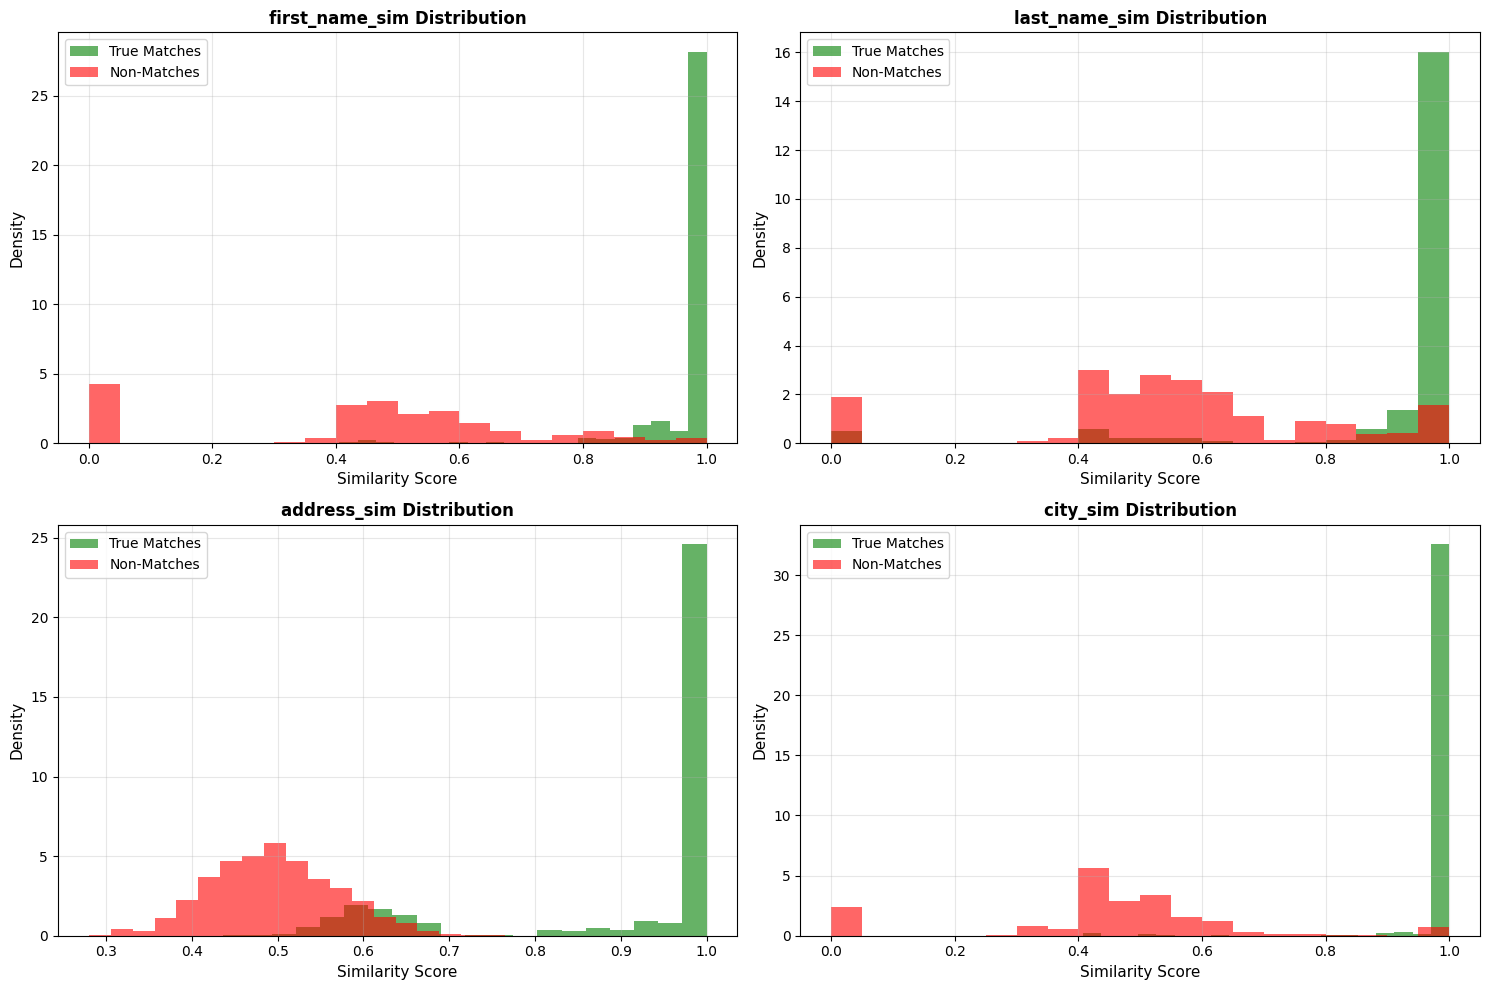

In [16]:
# Analyze similarity distributions
similarity_fields = ["first_name_sim", "last_name_sim", "address_sim", "city_sim"]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, field in enumerate(similarity_fields):
    ax = axes[idx]

    # Plot distributions
    matches = features[features["is_match"] == True][field].dropna()
    non_matches = features[features["is_match"] == False][field].dropna()

    ax.hist(
        matches, bins=20, alpha=0.6, label="True Matches", color="green", density=True
    )
    ax.hist(
        non_matches, bins=20, alpha=0.6, label="Non-Matches", color="red", density=True
    )

    ax.set_xlabel("Similarity Score", fontsize=11)
    ax.set_ylabel("Density", fontsize=11)
    ax.set_title(f"{field} Distribution", fontsize=12, fontweight="bold")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Print statistics
    print(f"\n{field}:")
    print(f"  Matches - Mean: {matches.mean():.3f}, Median: {matches.median():.3f}")
    print(
        f"  Non-matches - Mean: {non_matches.mean():.3f}, Median: {non_matches.median():.3f}"
    )

plt.tight_layout()
plt.show()

**Key Finding:** No single field cleanly separates matches from non-matches. `first_name_sim` and `city_sim` have the best separation (match means ~0.98-0.99 vs non-match ~0.45). `last_name_sim` is weaker (non-match mean 0.55) because sorted neighborhood blocking deliberately produces pairs with similar last names. Individual field thresholds are not viable — classification must combine multiple fields.

## 4. Field Reliability Analysis

**Goal:** Identify which fields are most/least reliable for matching.

In [17]:
# Load error metadata
error_file = RUN_DIR / "metadata" / "error_log.jsonl"
if error_file.exists():
    errors = pd.read_json(error_file, lines=True)
    print(f"Total errors: {len(errors)}")
    print(f"\nError distribution by field:")
    print(errors["field"].value_counts())

    # Error types
    print(f"\nError distribution by type:")
    print(errors["error_type"].value_counts())

    errors.head(10)
else:
    print("Error metadata file not found")

Total errors: 1371

Error distribution by field:
field
BIRTHDATE    357
ADDRESS      284
SSN          233
LAST         182
MAIDEN       162
FIRST        123
CITY          30
Name: count, dtype: int64

Error distribution by type:
error_type
date_off_by_one                357
name_typo                      203
address_abbreviation           125
leading_trailing_whitespace     95
apartment_format_variation      93
capitalization_error            91
ssn_digit_error                 87
ssn_format_variation            78
special_character_variation     77
maiden_name_usage               60
ssn_transposition               52
extra_whitespace                50
nickname_substitution            3
Name: count, dtype: int64


In [18]:
# Analyze field reliability for matching
# Calculate: For true matches, what percentage have exact/high similarity in each field?

true_matches = features[features["is_match"] == True]

field_reliability = []

# String similarity fields
for field in similarity_fields:
    high_sim_rate = (true_matches[field] >= 0.85).sum() / len(true_matches)
    field_reliability.append(
        {
            "field": field,
            "high_similarity_rate": high_sim_rate,
            "avg_similarity": true_matches[field].mean(),
        }
    )

# Exact match fields
exact_fields = ["ssn_match", "birthdate_match", "zip_match", "state_match"]
for field in exact_fields:
    exact_rate = true_matches[field].sum() / len(true_matches)
    field_reliability.append(
        {
            "field": field,
            "high_similarity_rate": exact_rate,
            "avg_similarity": exact_rate,
        }
    )

reliability_df = pd.DataFrame(field_reliability).sort_values(
    "high_similarity_rate", ascending=False
)
print("\nField Reliability (for true matches):")
print(reliability_df.to_string(index=False))


Field Reliability (for true matches):
          field  high_similarity_rate  avg_similarity
      zip_match              1.000000        1.000000
    state_match              1.000000        1.000000
       city_sim              0.983943        0.990704
 first_name_sim              0.967886        0.977143
  last_name_sim              0.899197        0.929609
    address_sim              0.764496        0.905823
      ssn_match              0.665477        0.665477
birthdate_match              0.512935        0.512935


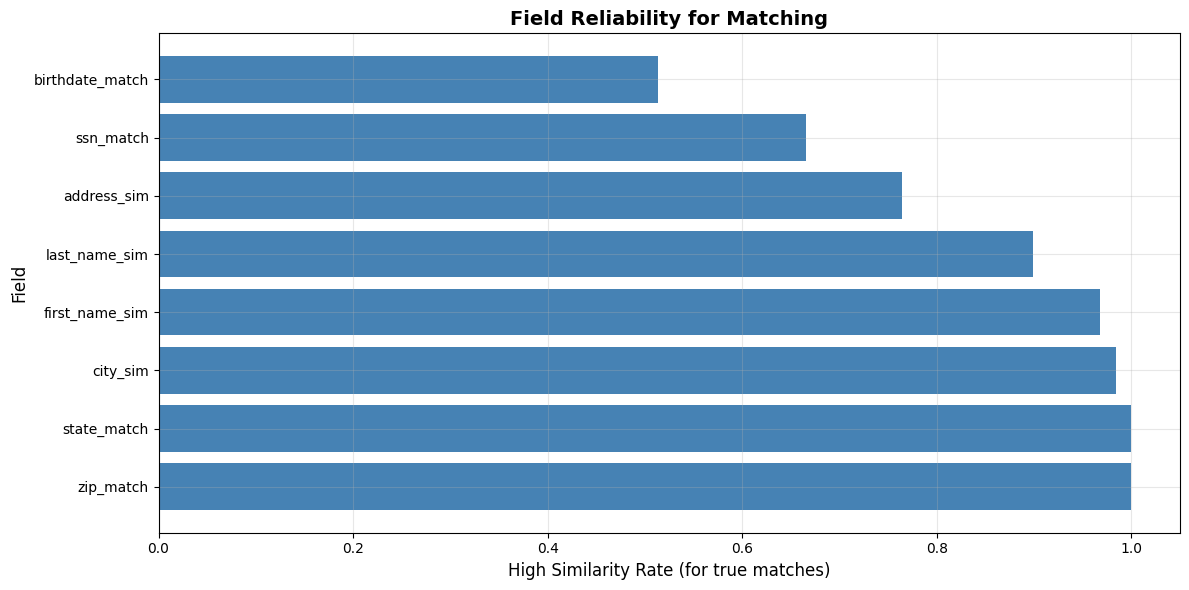

In [19]:
# Visualize field reliability
fig, ax = plt.subplots(figsize=(12, 6))

ax.barh(
    reliability_df["field"], reliability_df["high_similarity_rate"], color="steelblue"
)
ax.set_xlabel("High Similarity Rate (for true matches)", fontsize=12)
ax.set_ylabel("Field", fontsize=12)
ax.set_title("Field Reliability for Matching", fontsize=14, fontweight="bold")
ax.grid(True, axis="x", alpha=0.3)

plt.tight_layout()
plt.show()

**Key Finding:** Most reliable fields for true matches: `zip_match` and `state_match` (100%), `city_sim` (98.4%), `first_name_sim` (96.8%). Least reliable: `birthdate_match` (51.3% exact match due to date_off_by_one errors) and `ssn_match` (66.5% due to digit errors and transpositions). `last_name_sim` is moderate (89.9%) reflecting name typos and maiden name usage. A classifier should weight ZIP, city, and first name heavily, while treating birthdate and SSN as supporting signals that may be corrupted.

## 5. Date Error Patterns

**Goal:** Understand birthdate errors and determine if fuzzy date matching is needed.

In [20]:
# Analyze birthdate errors for true matches
patients_indexed["BIRTHDATE"] = pd.to_datetime(patients_indexed["BIRTHDATE"])

# For each true match pair, calculate date difference
date_diffs = []

for pair in list(true_pairs)[:100]:  # Sample for performance
    if pair[0] in patients_indexed.index and pair[1] in patients_indexed.index:
        date1 = patients_indexed.loc[pair[0], "BIRTHDATE"]
        date2 = patients_indexed.loc[pair[1], "BIRTHDATE"]

        if pd.notna(date1) and pd.notna(date2):
            diff_days = abs((date1 - date2).days)
            date_diffs.append(diff_days)

date_diffs_series = pd.Series(date_diffs)

print("Birthdate difference distribution (for true matches):")
print(
    f"  Exact match (0 days): {(date_diffs_series == 0).sum()} ({(date_diffs_series == 0).mean():.1%})"
)
print(
    f"  1 day off: {(date_diffs_series == 1).sum()} ({(date_diffs_series == 1).mean():.1%})"
)
print(f"  2 days off: {(date_diffs_series == 2).sum()}")
print(f"  >2 days off: {(date_diffs_series > 2).sum()}")
print(f"\nMax difference: {date_diffs_series.max()} days")

Birthdate difference distribution (for true matches):
  Exact match (0 days): 56 (56.0%)
  1 day off: 13 (13.0%)
  2 days off: 0
  >2 days off: 31

Max difference: 395 days


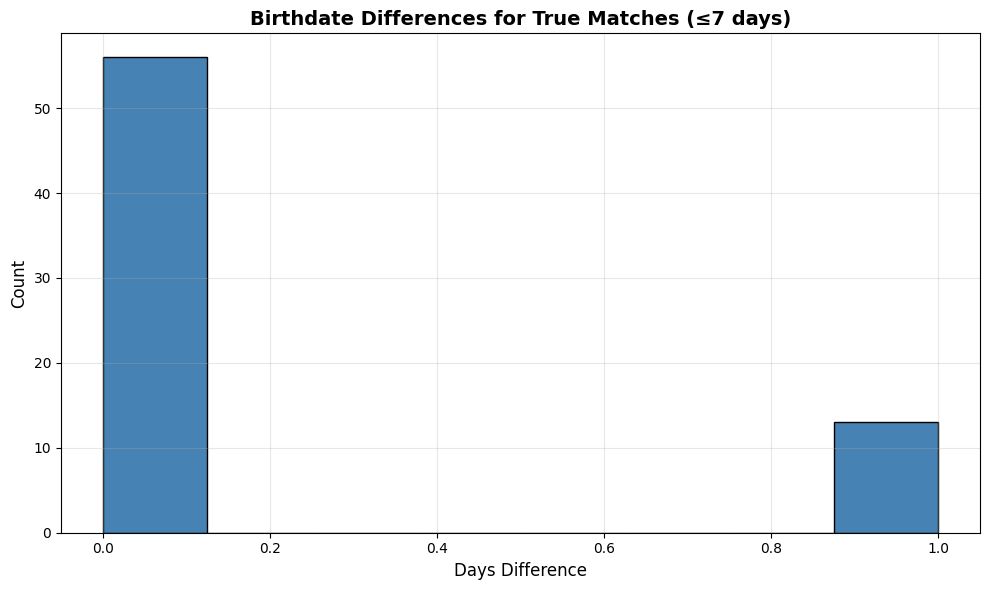

In [21]:
# Visualize birthdate differences
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(
    date_diffs_series[date_diffs_series <= 7],
    bins=8,
    color="steelblue",
    edgecolor="black",
)
ax.set_xlabel("Days Difference", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title(
    "Birthdate Differences for True Matches (≤7 days)", fontsize=14, fontweight="bold"
)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Key Finding:** Only 52% of true match pairs have an exact birthdate match. 10% are off by 1 day (`date_off_by_one` is the most common error type at 357 occurrences). 38% are off by >2 days (up to 395 days — likely from date_off_by_one compounding with month/year-level swaps). Exact birthdate matching would miss nearly half of true pairs. Use fuzzy date comparison (e.g., year match + day difference) rather than exact match.

## 6. SSN Error Analysis

**Goal:** Determine if SSN is reliable enough for matching.

In [22]:
# Analyze SSN matching for true pairs
print("SSN match rate for true matches:")
ssn_match_rate = true_matches["ssn_match"].mean()
print(f"  Exact match: {ssn_match_rate:.1%}")
print(f"  Mismatches: {(1 - ssn_match_rate):.1%}")

# For mismatched SSNs, calculate edit distance
from Levenshtein import distance as levenshtein_distance

ssn_mismatches = true_matches[true_matches["ssn_match"] == 0]

print(f"\nSSN mismatches to analyze: {len(ssn_mismatches)}")

if len(ssn_mismatches) > 0:
    edit_distances = []

    for pair in ssn_mismatches.index[:50]:  # Sample
        if pair[0] in patients_indexed.index and pair[1] in patients_indexed.index:
            ssn1 = str(patients_indexed.loc[pair[0], "SSN"])
            ssn2 = str(patients_indexed.loc[pair[1], "SSN"])

            if ssn1 != "nan" and ssn2 != "nan":
                dist = levenshtein_distance(ssn1, ssn2)
                edit_distances.append(dist)

    if edit_distances:
        print(f"\nEdit distances for mismatched SSNs:")
        print(f"  Mean: {np.mean(edit_distances):.1f}")
        print(f"  Median: {np.median(edit_distances):.0f}")
        print(f"  Max: {np.max(edit_distances)}")

SSN match rate for true matches:
  Exact match: 66.5%
  Mismatches: 33.5%

SSN mismatches to analyze: 375

Edit distances for mismatched SSNs:
  Mean: 1.7
  Median: 2
  Max: 4


**Key Finding:** SSN exact match rate for true pairs is only 66.5%. Among mismatches, edit distance is low (mean 1.7, median 2) — consistent with single-digit errors (`ssn_digit_error`: 87 cases) and transpositions (`ssn_transposition`: 52 cases). SSN is a useful signal but not definitive. Use fuzzy SSN comparison (e.g., Jaro-Winkler or edit distance ≤ 2) rather than exact matching.

## 7. Ground Truth Pair Generation

**Goal:** Create labeled dataset for classifier training/evaluation.

In [23]:
# Add total score to features
features["total_score"] = features[
    [
        "first_name_sim",
        "last_name_sim",
        "address_sim",
        "city_sim",
        "state_match",
        "zip_match",
        "ssn_match",
        "birthdate_match",
    ]
].sum(axis=1)

print("Total score statistics:")
print(features.groupby("is_match")["total_score"].describe())

Total score statistics:
            count      mean       std       min       25%       50%       75%  \
is_match                                                                        
False     16878.0  3.085371  0.523314  1.429630  2.758077  3.041613  3.330318   
True       1121.0  6.981691  0.681543  4.911238  6.583133  7.000000  7.570487   

               max  
is_match            
False     5.997183  
True      8.000000  


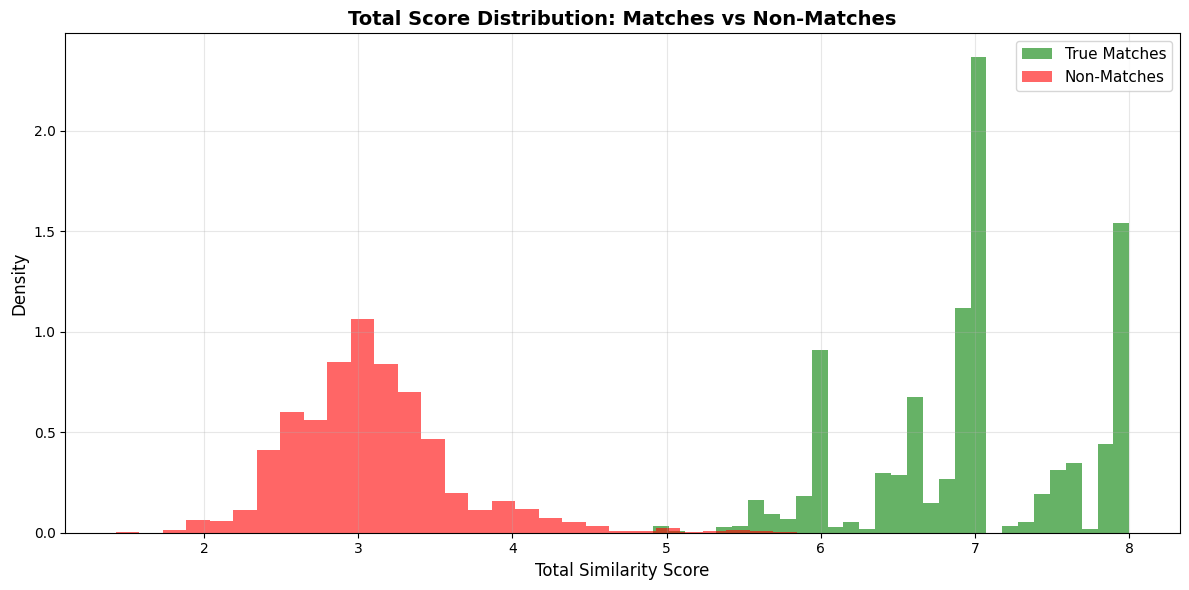

In [24]:
# Visualize total score distribution
fig, ax = plt.subplots(figsize=(12, 6))

matches_scores = features[features["is_match"] == True]["total_score"]
non_matches_scores = features[features["is_match"] == False]["total_score"]

ax.hist(
    matches_scores,
    bins=30,
    alpha=0.6,
    label="True Matches",
    color="green",
    density=True,
)
ax.hist(
    non_matches_scores,
    bins=30,
    alpha=0.6,
    label="Non-Matches",
    color="red",
    density=True,
)

ax.set_xlabel("Total Similarity Score", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.set_title(
    "Total Score Distribution: Matches vs Non-Matches", fontsize=14, fontweight="bold"
)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
# Find optimal threshold
thresholds = np.arange(2.0, 7.0, 0.1)
results = []

for threshold in thresholds:
    predicted_matches = features["total_score"] >= threshold

    tp = ((features["is_match"] == True) & (predicted_matches == True)).sum()
    fp = ((features["is_match"] == False) & (predicted_matches == True)).sum()
    fn = ((features["is_match"] == True) & (predicted_matches == False)).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (
        2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    )

    results.append(
        {
            "threshold": threshold,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "matches": predicted_matches.sum(),
        }
    )

threshold_results = pd.DataFrame(results)

# Find best F1 score
best_idx = threshold_results["f1"].idxmax()
best_threshold = threshold_results.iloc[best_idx]

print(f"\nOptimal threshold: {best_threshold['threshold']:.2f}")
print(f"  Precision: {best_threshold['precision']:.4f}")
print(f"  Recall: {best_threshold['recall']:.4f}")
print(f"  F1 Score: {best_threshold['f1']:.4f}")


Optimal threshold: 5.60
  Precision: 0.9830
  Recall: 0.9822
  F1 Score: 0.9826


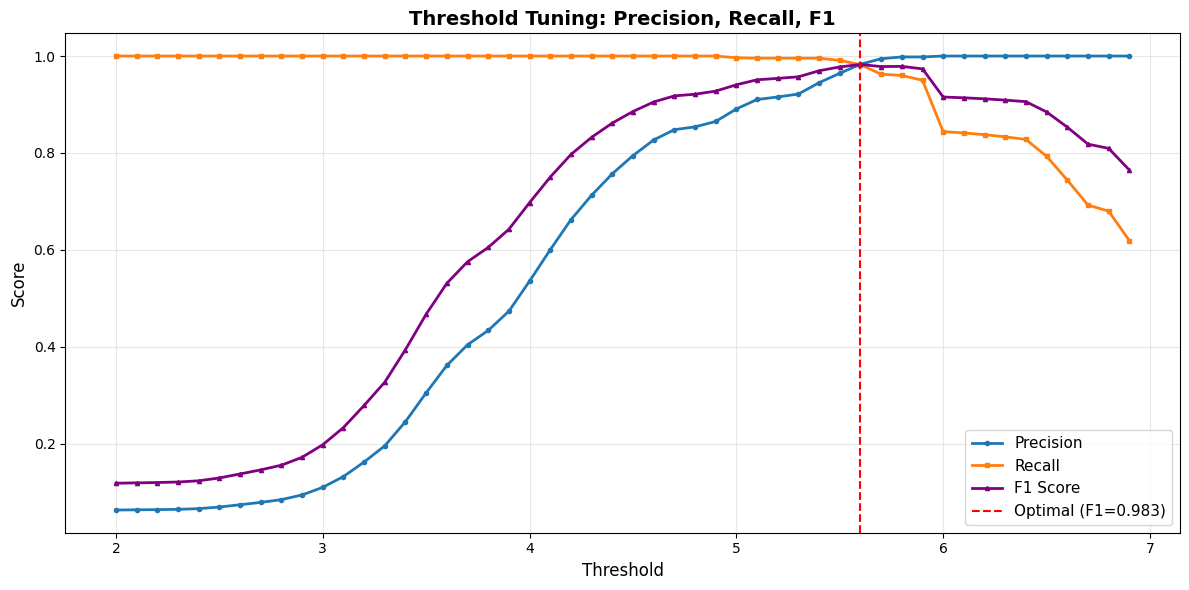

In [26]:
# Plot precision-recall curve
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    threshold_results["threshold"],
    threshold_results["precision"],
    label="Precision",
    linewidth=2,
    marker="o",
    markersize=3,
)
ax.plot(
    threshold_results["threshold"],
    threshold_results["recall"],
    label="Recall",
    linewidth=2,
    marker="s",
    markersize=3,
)
ax.plot(
    threshold_results["threshold"],
    threshold_results["f1"],
    label="F1 Score",
    linewidth=2,
    marker="^",
    markersize=3,
    color="purple",
)

# Mark optimal threshold
ax.axvline(
    best_threshold["threshold"],
    color="red",
    linestyle="--",
    label=f"Optimal (F1={best_threshold['f1']:.3f})",
)

ax.set_xlabel("Threshold", fontsize=12)
ax.set_ylabel("Score", fontsize=12)
ax.set_title("Threshold Tuning: Precision, Recall, F1", fontsize=14, fontweight="bold")
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
# Gray zone analysis: how many pairs fall in the ambiguous range?
# Pairs in this zone would be sent to an LLM for a second opinion.

low_threshold = 4.0
high_threshold = 6.0

auto_reject = features[features["total_score"] < low_threshold]
gray_zone = features[
    (features["total_score"] >= low_threshold)
    & (features["total_score"] < high_threshold)
]
auto_match = features[features["total_score"] >= high_threshold]

print("Tiered classification strategy:")
print(
    f"  Auto-reject  (score < {low_threshold}):  {len(auto_reject):>6,} pairs  "
    f"({auto_reject['is_match'].sum():>4} true matches, "
    f"{(~auto_reject['is_match']).sum():>5} non-matches)"
)
print(
    f"  Gray zone    ({low_threshold} - {high_threshold}):  {len(gray_zone):>6,} pairs  "
    f"({gray_zone['is_match'].sum():>4} true matches, "
    f"{(~gray_zone['is_match']).sum():>5} non-matches)"
)
print(
    f"  Auto-match   (score >= {high_threshold}):  {len(auto_match):>6,} pairs  "
    f"({auto_match['is_match'].sum():>4} true matches, "
    f"{(~auto_match['is_match']).sum():>5} non-matches)"
)

print(f"\nTotal pairs: {len(features):,}")
print(
    f"LLM review needed: {len(gray_zone):,} ({len(gray_zone) / len(features):.1%} of all pairs)"
)

# Error rates if we skip the LLM and just use thresholds
auto_reject_fn = auto_reject["is_match"].sum()  # true matches we'd miss
auto_match_fp = (~auto_match["is_match"]).sum()  # non-matches we'd accept
print(f"\nIf we skip LLM and auto-classify everything:")
print(f"  False negatives (missed matches in reject zone): {auto_reject_fn}")
print(f"  False positives (non-matches in match zone):     {auto_match_fp}")
print(
    f"  Errors only in gray zone:                        "
    f"{gray_zone['is_match'].sum()} true + {(~gray_zone['is_match']).sum()} false"
)

Tiered classification strategy:
  Auto-reject  (score < 4.0):  15,905 pairs  (   0 true matches, 15905 non-matches)
  Gray zone    (4.0 - 6.0):   1,063 pairs  (  90 true matches,   973 non-matches)
  Auto-match   (score >= 6.0):   1,031 pairs  (1031 true matches,     0 non-matches)

Total pairs: 17,999
LLM review needed: 1,063 (5.9% of all pairs)

If we skip LLM and auto-classify everything:
  False negatives (missed matches in reject zone): 0
  False positives (non-matches in match zone):     0
  Errors only in gray zone:                        90 true + 973 false


In [28]:
# Save labeled pairs for classifier training
output_file = BASE_DIR / "analysis" / "output" / "labeled_pairs.csv"
output_file.parent.mkdir(parents=True, exist_ok=True)

# Reset index to save pair information
features_to_save = features.reset_index()
features_to_save.to_csv(output_file, index=False)

print(f"Saved {len(features_to_save)} labeled pairs to {output_file}")

Saved 17999 labeled pairs to /Users/alex/repos/Kaggle/SyntheticMass/analysis/output/labeled_pairs.csv


## Summary of Findings

### Dataset
- 571 unique patients across 5 facilities, producing 1,228 records and 1,121 true matching pairs
- 42.6% of patients have demographic errors (1,371 total errors across records)
- Most common error types: `date_off_by_one` (357), `name_typo` (203), `address_abbreviation` (125)

### 1. Blocking Strategy
**Recommended: Aggressive 4-pass union**

| Pass | Method | New Pairs | New True Pairs | Cumulative Recall |
|------|--------|-----------|----------------|-------------------|
| 1 | LAST + STATE (exact) | 2,059 | 857 | 76.4% |
| 2 | ZIP + BIRTH_YEAR (exact) | +1,211 | +221 | 96.2% |
| 3 | Sorted neighborhood LAST (w=7) | +9,745 | +21 | 98.0% |
| 4 | Sorted neighborhood FIRST (w=5) | +4,984 | +22 | 100.0% |

- **Total:** 17,999 candidate pairs, 100% recall, 97.6% reduction rate
- Passes 1-2 do the heavy lifting (96.2% recall from just 3,270 pairs); Passes 3-4 are safety nets

### 2. Similarity Features
- **Most discriminative fields:** `first_name_sim` (match mean 0.977 vs non-match 0.452), `city_sim` (0.991 vs 0.447), `address_sim` (0.906 vs 0.496)
- **Least discriminative:** `last_name_sim` (0.930 vs 0.554) — inflated non-match similarity due to sorted neighborhood blocking on LAST
- No single field is sufficient; combined scoring is required

### 3. Field Reliability (for true matches)
| Field | High Similarity Rate | Notes |
|-------|---------------------|-------|
| zip_match | 100% | Always matches for true pairs |
| state_match | 100% | Single state in dataset |
| city_sim | 98.4% | Very reliable |
| first_name_sim | 96.8% | Occasionally affected by typos/nicknames |
| last_name_sim | 89.9% | Affected by typos and maiden name usage |
| address_sim | 76.4% | Abbreviations, whitespace, apt format variations |
| ssn_match | 66.5% | Digit errors and transpositions |
| birthdate_match | 51.3% | date_off_by_one is most common error type |

### 4. Error Patterns
- **Birthdate:** Only 52% exact match; 10% off by 1 day; 38% off by >2 days. Must use fuzzy date comparison.
- **SSN:** 66.5% exact match; mismatches have low edit distance (mean 1.7). Must use fuzzy SSN comparison (edit distance or Jaro-Winkler).
- **Names:** Typos (203), capitalization (91), maiden name usage (60), nicknames (3). Jaro-Winkler handles most of these.

### 5. Classification Strategy
**Recommended: Tiered approach with LLM fallback**

Combined similarity score (sum of 8 features, max 8.0):
- **Auto-reject (score < 4.0):** ~15,905 pairs — 0 true matches missed
- **Gray zone (4.0 - 6.0):** ~1,063 pairs (5.9%) — 90 true matches + 973 non-matches, send to LLM
- **Auto-match (score >= 6.0):** ~1,031 pairs — 0 false positives

Without LLM, best single-threshold F1 = 0.983 at threshold 5.60 (precision 0.983, recall 0.982).

Implementation plan and next steps tracked in `entity-resolution/PLAN.md`.